# 🌪️ Natural Disaster Tweet Classification Project

This notebook explores and models tweet data to classify whether a tweet is about a real disaster or not. We'll clean and preprocess the data in several ways, visualize it, generate multiple datasets, and run various NLP models to compare performance.

---

## 📌 Table of Contents
1. [Import Data](#import-data)
2. [Initial Data Cleaning](#initial-data-cleaning)
   - Fix corrupted characters
   - Handle duplicates and nulls
   - Normalize text
3. [Exploratory Data Analysis (EDA)](#eda)
   - Target distribution
   - Tweet length
   - Hashtag/@/URL usage
   - Word clouds
4. [Text Preprocessing Variants](#preprocessing-variants)
   - Dataset v1: Lowercase + Basic Cleaning
   - Dataset v2: Remove hashtags/URLs/@/emojis
   - Dataset v3: Lemmatization
   - Dataset v4: Tokenization (NLTK vs TweetTokenizer)
5. [Saving Preprocessed Datasets](#save-datasets)
6. [Word Cloud Comparison](#wordclouds)
7. [Modeling Pipeline](#modeling)
   - TF-IDF Vectorization
   - Train/Test Split
   - Models:
     - Multinomial Naive Bayes
     - Logistic Regression
     - Passive Aggressive Classifier
     - SVM
   - Cross-validation & Metrics
8. [Performance Comparison](#comparison)
9. [Conclusions & Next Steps](#conclusion)

---
## 1. 📥 Import Data <a name="import-data"></a>
---

In [ ]:
# ⚠️ Warning Handling
import warnings
warnings.simplefilter(action='ignore', category=Warning)

# 📦 Core Dependencies
import chardet
import numpy as np
import os
import pandas as pd
import re
import string
from collections import Counter
!pip install unidecode
from unidecode import unidecode

# 📊 Data Visualization
import matplotlib.pyplot as plt
from matplotlib import cm  # for colormap
from matplotlib.colors import to_hex
from matplotlib.colors import ListedColormap
import seaborn as sns
from wordcloud import WordCloud
# For inline plotting in Jupyter
%matplotlib inline

# 🧠 Natural Language Processing (NLTK)
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

# ⚙️ Machine Learning - Models & Evaluation
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    f1_score, precision_score, recall_score, roc_auc_score, roc_curve
)
from sklearn.model_selection import (
    StratifiedKFold, cross_val_score, cross_validate, learning_curve, train_test_split
)
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# 🔢 Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 8.1 MB/s eta 0:00:00


In [ ]:
# nltk downloads
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('omw-1.4')
# Spacy
# !python -m spacy download en_core_web_md
# nlp = spacy.load("en_core_web_md")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
# 📥 Load and Inspect Data

# Detect encoding of the training CSV file to avoid character corruption
with open("data/train.csv", "rb") as f:
    raw_data = f.read(100_000)  # Read the first 100KB
    result = chardet.detect(raw_data)
    detected_encoding = result['encoding']

# Fallback in case encoding couldn't be detected
if detected_encoding is None:
    detected_encoding = 'utf-8'

print(f"Detected Encoding: {detected_encoding}")

# Load training and test datasets using the detected encoding
train_data = pd.read_csv("data/train.csv", encoding=detected_encoding)
test_data = pd.read_csv("data/test.csv", encoding=detected_encoding)

# Reset index to ensure consistency
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

# 🔍 Preview the first few rows of the training data
train_data.head()


Detected Encoding: utf-8


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


---
## 2. 🧼 Initial Data Cleaning <a name="initial-data-cleaning"></a>
- Fix known corrupted sequences
- Remove duplicates
- Fill or drop null values
- Normalize text (e.g., remove non-ASCII)
---

### 2.1 🔍 Detect Non-ASCII Characters


In [ ]:
def get_corrupted_char_counts(series):
    """
    Count non-ASCII characters in a Pandas Series of text.

    Args:
        series (pd.Series): Column of text to inspect.

    Returns:
        Counter: Dictionary of non-ASCII characters and their frequencies.
    """
    counts = Counter()
    for text in series:
        if isinstance(text, str):
            for char in re.findall(r"[^\x00-\x7F]", text):
                counts[char] += 1
    return counts


In [ ]:

def contains_non_ascii(text):
    """
    Check if a text contains any non-ASCII characters.

    Args:
        text (str): Input text

    Returns:
        bool: True if non-ASCII characters found, False otherwise
    """
    return bool(re.search(r'[^\x00-\x7F]', str(text)))


In [ ]:
# Run corrupted character detection
corrupted_counts = get_corrupted_char_counts(train_data['text'])
print("Top corrupted characters:", corrupted_counts.most_common(10))

# Identify rows containing non-ASCII characters in any object column
df_corrupted = train_data[train_data.select_dtypes(include='object').applymap(contains_non_ascii).any(axis=1)]


Top corrupted characters: [('\x89', 797), ('Û', 794), ('ª', 191), ('å', 96), ('Ï', 69), ('Ê', 66), ('÷', 49), ('Ò', 45), ('\x9d', 44), ('Ó', 33)]


In [ ]:
df_corrupted.head()

,id,keyword,location,text,target
38,56,ablaze,NaN,Barbados #Bridgetown JAMAICA ÛÒ Two cars set ...,1
52,76,ablaze,Barbados,SANTA CRUZ ÛÓ Head of the St Elizabeth Police...,0
53,77,ablaze,Anaheim,Police: Arsonist Deliberately Set Black Church...,1
57,81,ablaze,"Sao Paulo, Brazil",Set our hearts ablaze and every city was a gif...,0
71,102,accident,"St. Louis, MO",#stlouis #caraccidentlawyer Speeding Among Top...,0


### 2.2 🧹 Apply Replacement for Known Corrupted Sequences


In [ ]:
# Replace known misencoded sequences in specified text columns
corrections = {
    "ÛÒ": "-", "\x89ÛÓ": "-", "@\x89Û_": "@_", "\x89Û_": "_",
    "ã¢": "TM", "\x89ÛÏ": '"', "\x89Û\x9d": '"', "\x89Ûª": "'",
    "åÊ": " ", "\x89Û÷": "'", "å£": "£", "# ": "#", "å¤}": "",
    "å_?": "", "åÇ": "...", "åÈ": ".", "ÌÑ1": "#1", "ÌÑ": "x",
    "Ìü": "", "Ì´": "'", "\n\n": " ", "Ì©": "e", "Ì¼": "u",
    "\x89Û¢": '"', "å¡": "!", "&amp;": " ", "å«": "'",
    "\x89âÂ": "", "å¨": "", "å¬": "", "Ì¤": "c", "Ì_n": "an",
    "Ì_": "i", "Nå¼": "number", "å_": "", "é": "e", "ón": "an",
    "ç": "c", "í": "i", "Ì¢": "", "\n": "", "å©": " @", "º": "o",
}

def apply_text_corrections(df, columns, corrections):
    for bad, good in corrections.items():
        for col in columns:
            df[col] = df[col].str.replace(bad, good, regex=False)
    return df


In [ ]:
train_data = apply_text_corrections(train_data, ['text', 'location'], corrections)

### 2.3 🔠 Normalize Remaining Unicode Characters (e.g., Accents)


In [ ]:
def normalize_column_text(df, columns):
    """
    Apply unidecode normalization to specific columns of a dataframe.

    Args:
        df (pd.DataFrame): The input dataframe.
        columns (list): List of text columns to normalize.

    Returns:
        pd.DataFrame: DataFrame with normalized text columns.
    """
    for col in columns:
        df[col] = df[col].apply(lambda x: unidecode(str(x)) if isinstance(x, str) else x)
    return df


In [ ]:
# Apply normalization
train_data = normalize_column_text(train_data, ['text', 'location'])

### 2.4 🧹 Data Preprocessing

#### 📤 Drop Unnecessary Columns  
Remove columns that are not useful for modeling (e.g., `location`, `id`).

#### 🕳️ Handle Missing Values  
Detect and remove rows containing `NaN` values after dropping unused columns.

#### ⚠️ Remove Conflicting Labels  
Exclude tweets that appear with the same text but different target labels to reduce noise.

#### 📋 Remove Duplicates  
Drop duplicate rows based on meaningful features like `text`, `target`, and optionally `keyword`.


In [ ]:
def prepare_dataset(df: pd.DataFrame, keyword_strategy: str = "prepend") -> pd.DataFrame:
    """
    Cleans and deduplicates the tweet dataset with optional keyword handling.

    Steps:
    - Drop 'id' and 'location' columns
    - Drop rows with NaN values after column drops
    - Remove rows with same text but conflicting target labels
    - Drop duplicates based on relevant columns (before modifying 'text')
    - Handle 'keyword' based on the strategy:
        - 'prepend': Prepend keyword to the text and drop the column
        - 'keep': Keep keyword column
        - 'drop': Drop keyword column

    Parameters:
    -----------
    df : pd.DataFrame
        Original DataFrame with columns: id, keyword, location, text, target.

    keyword_strategy : str
        How to handle the 'keyword' column. One of:
            - 'prepend': Prepend keyword to text and drop keyword column
            - 'keep': Keep the keyword column as-is
            - 'drop': Drop the keyword column completely

    Returns:
    --------
    pd.DataFrame
        A cleaned and deduplicated DataFrame ready for modeling.
    """
    assert keyword_strategy in ['prepend', 'keep', 'drop'], "Invalid keyword_strategy. Choose from 'prepend', 'keep', or 'drop'."

    # Drop 'id' and 'location' columns
    df_cleaned = df.drop(columns=['id', 'location'], errors='ignore').copy()

    # Drop any rows with NaN values
    before_nan = len(df_cleaned)
    df_cleaned = df_cleaned.dropna().reset_index(drop=True)
    after_nan = len(df_cleaned)
    print(f"Dropped {before_nan - after_nan} rows with NaN values after dropping unused columns.")

    # Remove rows with same text and different target values (conflicts)
    conflict_texts = (
        df_cleaned.groupby('text')['target']
        .nunique()
        .reset_index()
        .query('target > 1')['text']
    )

    before_conflict = len(df_cleaned)
    df_cleaned = df_cleaned[~df_cleaned['text'].isin(conflict_texts)].reset_index(drop=True)
    after_conflict = len(df_cleaned)
    print(f"Removed {before_conflict - after_conflict} rows with conflicting labels on identical text.")

    # Deduplicate BEFORE keyword modification
    dedup_cols = ['text', 'target']
    if keyword_strategy == 'keep' and 'keyword' in df_cleaned.columns:
        dedup_cols.insert(1, 'keyword')

    before_dupes = len(df_cleaned)
    df_deduped = df_cleaned.drop_duplicates(subset=dedup_cols).reset_index(drop=True)
    after_dupes = len(df_deduped)
    print(f"Dropped {before_dupes - after_dupes} duplicates based on: {dedup_cols}")

    # Handle keyword column after deduplication
    if keyword_strategy == 'prepend' and 'keyword' in df_deduped.columns:
        df_deduped['text'] = df_deduped.apply(
            lambda row: f"{row['keyword']} {row['text']}" if pd.notnull(row['keyword']) else row['text'],
            axis=1
        )
        df_deduped.drop(columns=['keyword'], inplace=True)

    elif keyword_strategy == 'drop' and 'keyword' in df_deduped.columns:
        df_deduped.drop(columns=['keyword'], inplace=True)

    return df_deduped


In [ ]:
# Prepend keyword to text, then drop keyword column
df_keyword_prepended = prepare_dataset(train_data, keyword_strategy="prepend")

# Drop keyword completely
df_keyword_dropped = prepare_dataset(train_data, keyword_strategy="drop")

# Keep keyword as a separate column
df_keyword_kept = prepare_dataset(train_data, keyword_strategy="keep")


Dropped 61 rows with NaN values after dropping unused columns.
Removed 55 rows with conflicting labels on identical text.
Dropped 68 duplicates based on: ['text', 'target']
Dropped 61 rows with NaN values after dropping unused columns.
Removed 55 rows with conflicting labels on identical text.
Dropped 68 duplicates based on: ['text', 'target']
Dropped 61 rows with NaN values after dropping unused columns.
Removed 55 rows with conflicting labels on identical text.
Dropped 53 duplicates based on: ['text', 'keyword', 'target']


### 2.5 💾 Save Cleaned Datasets for Reuse

In [ ]:
# Define output file paths
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Save datasets to CSV
df_keyword_prepended.to_csv(f"{output_dir}/train_keyword_prepended.csv", index=False)
df_keyword_dropped.to_csv(f"{output_dir}/train_keyword_dropped.csv", index=False)
df_keyword_kept.to_csv(f"{output_dir}/train_keyword_kept.csv", index=False)

print("✅ All cleaned datasets saved to 'processed_data/' folder.")

✅ All cleaned datasets saved to 'processed_data/' folder.



---

## 3. 📊 Exploratory Data Analysis (EDA) <a name="eda"></a>
- Dataset Overview
- Distribution of target labels (0/1)
- Tweet length histogram
- Hashtag Analysis
- @mention Analysis
- URL Analysis
- Emoji presence
- Sample Tweet Analysis

---

### 3.1 📈 Dataset Overview
Dataset shape (rows, columns)


Column data types


Missing value summary


Unique value count per column


Basic text length statistics


In [ ]:
def dataset_overview(df: pd.DataFrame, text_column: str = "text") -> None:
    """
    Displays key statistics and information about the structure of the dataset.

    Parameters:
    -----------
    df : pd.DataFrame
        The dataset to summarize.
    text_column : str, default="text"
        Name of the column containing tweet text for length analysis.
    """

    print("🔍 Dataset Overview")
    print("=" * 40)

    # Shape
    print(f"Shape (rows, columns): {df.shape}")

    # Column data types
    print("\n📦 Data Types:")
    print(df.dtypes)

    # Null values
    print("\n🕳️ Missing Values per Column:")
    print(df.isnull().sum())

    # Unique values
    print("\n🔢 Unique Values per Column:")
    print(df.nunique())

    # Text length stats
    if text_column in df.columns:
        df['text_length'] = df[text_column].apply(len)
        print("\n✏️ Text Length Statistics:")
        print(df['text_length'].describe())
    else:
        print(f"\n⚠️ Text column '{text_column}' not found in DataFrame.")

    print("=" * 40)


In [ ]:
dataset_overview(df_keyword_prepended)
dataset_overview(df_keyword_dropped)
dataset_overview(df_keyword_kept)


🔍 Dataset Overview
Shape (rows, columns): (7429, 2)

📦 Data Types:
text      object
target     int64
dtype: object

🕳️ Missing Values per Column:
text      0
target    0
dtype: int64

🔢 Unique Values per Column:
text      7429
target       2
dtype: int64

✏️ Text Length Statistics:
count    7429.000000
mean      110.423206
std        34.012873
min        15.000000
25%        87.000000
50%       116.000000
75%       142.000000
max       164.000000
Name: text_length, dtype: float64
🔍 Dataset Overview
Shape (rows, columns): (7429, 2)

📦 Data Types:
text      object
target     int64
dtype: object

🕳️ Missing Values per Column:
text      0
target    0
dtype: int64

🔢 Unique Values per Column:
text      7429
target       2
dtype: int64

✏️ Text Length Statistics:
count    7429.000000
mean      100.701710
std        33.338793
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: text_length, dtype: float64
🔍 Dataset Overview
Shape (rows

### 3.2 🎯 Target Distribution
Count and proportion of each target class (0 = Non-Disaster, 1 = Disaster)


Bar chart of target frequencies


Brief comment on class balance


In [ ]:
def plot_target_distribution(df: pd.DataFrame, title_suffix: str = ""):
    """
    Displays the count, proportion, and bar plot of target classes.

    Parameters:
    -----------
    df : pd.DataFrame
        The dataset with a 'target' column.

    title_suffix : str, optional
        Optional label to append to the plot title (e.g., ' (with keyword)')
    """
    # Count and percentage
    counts = df['target'].value_counts().sort_index()
    percentages = df['target'].value_counts(normalize=True).sort_index() * 100

    # Display stats
    print("Target Class Counts:")
    print(counts)
    print("\nTarget Class Proportions:")
    print(percentages.round(2).astype(str) + " %")

    # Plot
    plt.figure(figsize=(7, 5))
    sns.countplot(x='target', data=df, palette=sns.color_palette("viridis", 2))
    plt.title(f'Target Class Distribution{title_suffix}')
    plt.xlabel('Target')
    plt.ylabel('Count')
    plt.xticks([0, 1], ['Non-Disaster (0)', 'Disaster (1)'])
    plt.tight_layout()
    plt.show()


Target Class Counts:
target
0    4278
1    3151
Name: count, dtype: int64

Target Class Proportions:
target
0    57.59 %
1    42.41 %
Name: proportion, dtype: object


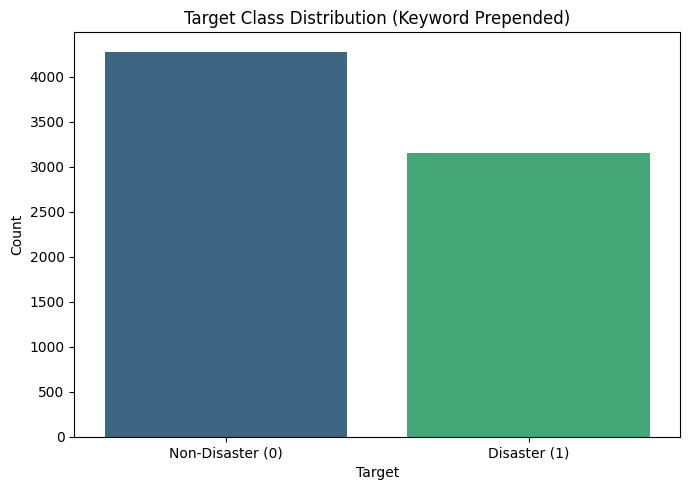

Target Class Counts:
target
0    4278
1    3151
Name: count, dtype: int64

Target Class Proportions:
target
0    57.59 %
1    42.41 %
Name: proportion, dtype: object


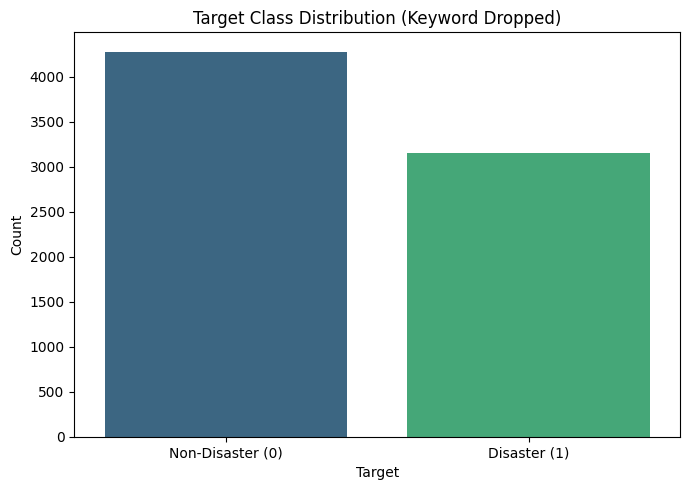

Target Class Counts:
target
0    4280
1    3164
Name: count, dtype: int64

Target Class Proportions:
target
0    57.5 %
1    42.5 %
Name: proportion, dtype: object


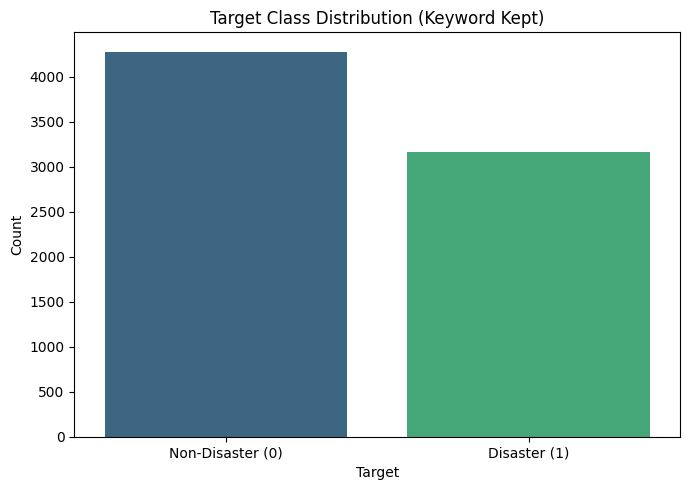

In [ ]:
# Visualize target class distribution for each version of the dataset

plot_target_distribution(df_keyword_prepended, title_suffix=" (Keyword Prepended)")
plot_target_distribution(df_keyword_dropped, title_suffix=" (Keyword Dropped)")
plot_target_distribution(df_keyword_kept, title_suffix=" (Keyword Kept)")


---

> ⚖️ **Class Balance Consideration**  
> A brief review of best practices suggests that datasets with class ratios between **50/50 and 40/60** are generally considered **balanced**.  
>  
> Since our target distribution falls within this range, we will **proceed without applying any class balancing techniques**.

---



### 3.3 📝 Tweet Length Analysis
Histogram of tweet lengths


Length distribution per class (0 vs. 1)


Boxplots

Sample of longest tweets


In [ ]:
def plot_tweet_length_distribution(df: pd.DataFrame, dataset_name: str = "Dataset"):
    """
    Plots the distribution of tweet lengths overall and by target class.

    Parameters:
    -----------
    df : pd.DataFrame
        Dataset containing at least 'text' and 'target' columns.
    dataset_name : str
        Name of the dataset (used in titles).
    """
    # Calculate tweet lengths if not already present
    if 'length' not in df.columns:
        df['length'] = df['text'].apply(len)

    # Overall Length Distribution
    plt.figure(figsize=(10, 5))
    sns.histplot(df['length'], bins=50, kde=False, color='mediumpurple')
    plt.title(f'{dataset_name}: Distribution of Tweet Lengths')
    plt.xlabel('Tweet Length (characters)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

    # Length Distribution by Target
    plt.figure(figsize=(12, 5))
    sns.histplot(
        data=df,
        x='length',
        hue='target',
        bins=50,
        palette='viridis',
        multiple='stack'
    )
    plt.title(f'{dataset_name}: Tweet Length by Class (0 = Non-Disaster, 1 = Disaster)')
    plt.xlabel('Tweet Length (characters)')
    plt.ylabel('Frequency')
    plt.legend(title='Target', labels=['Non-Disaster (0)', 'Disaster (1)'])  # Explicit legend
    plt.tight_layout()
    plt.show()

    # Boxplot by Target
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='target', y='length', data=df, palette='Set2')
    plt.title(f'{dataset_name}: Boxplot of Tweet Lengths by Class')
    plt.xlabel('Target')
    plt.ylabel('Tweet Length')
    plt.xticks([0, 1], ['Non-Disaster', 'Disaster'])
    plt.tight_layout()
    plt.show()


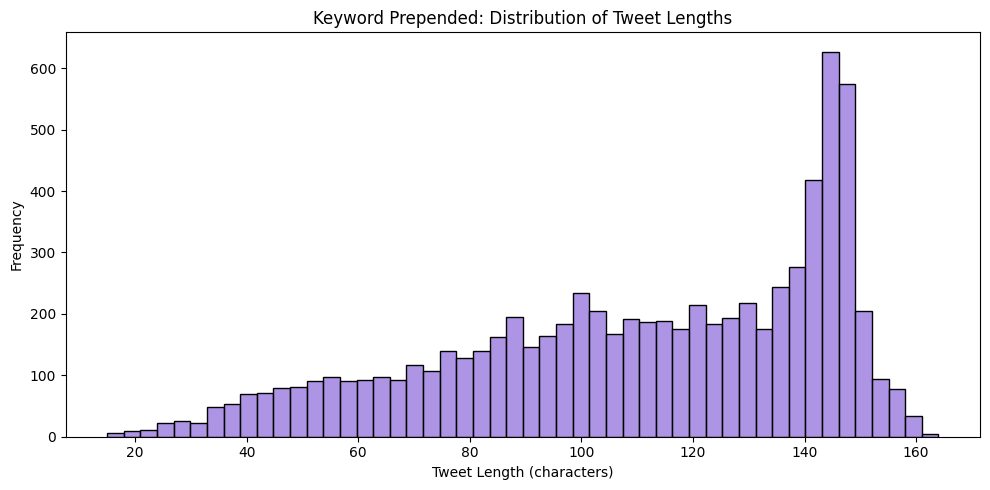

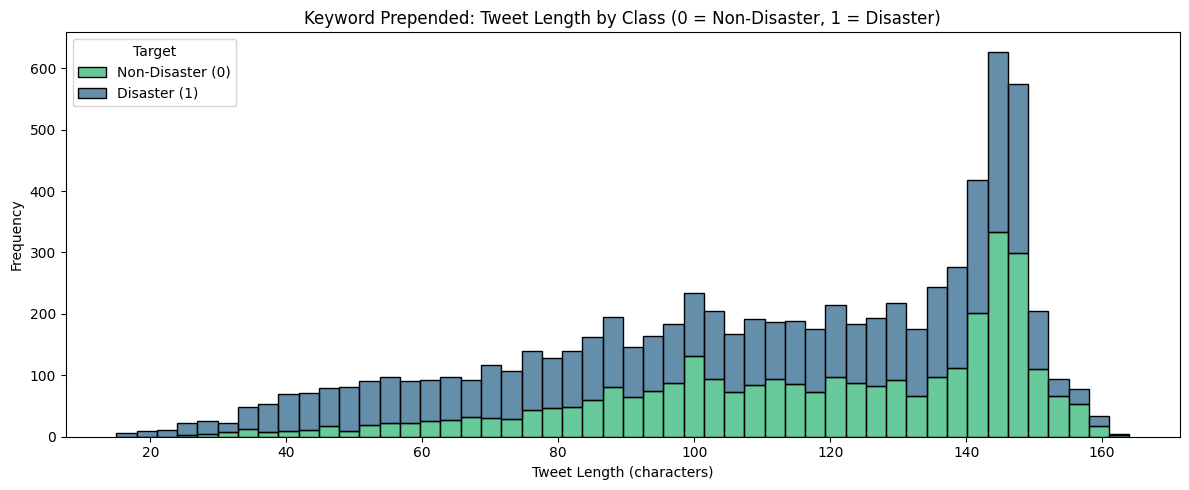

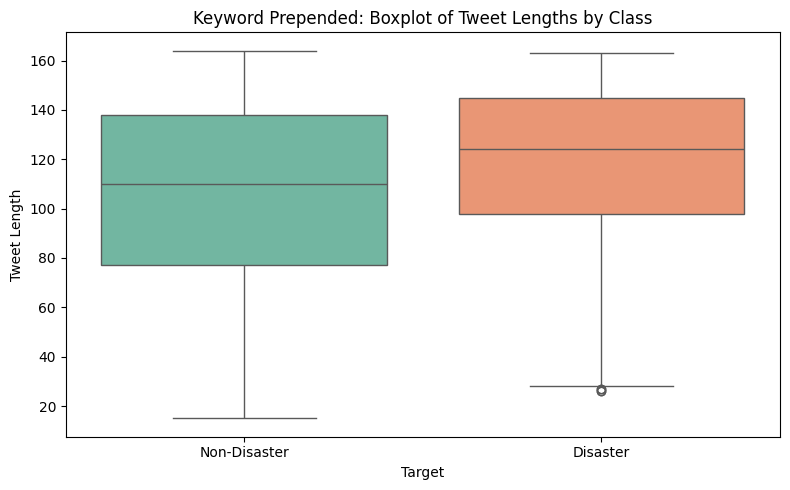

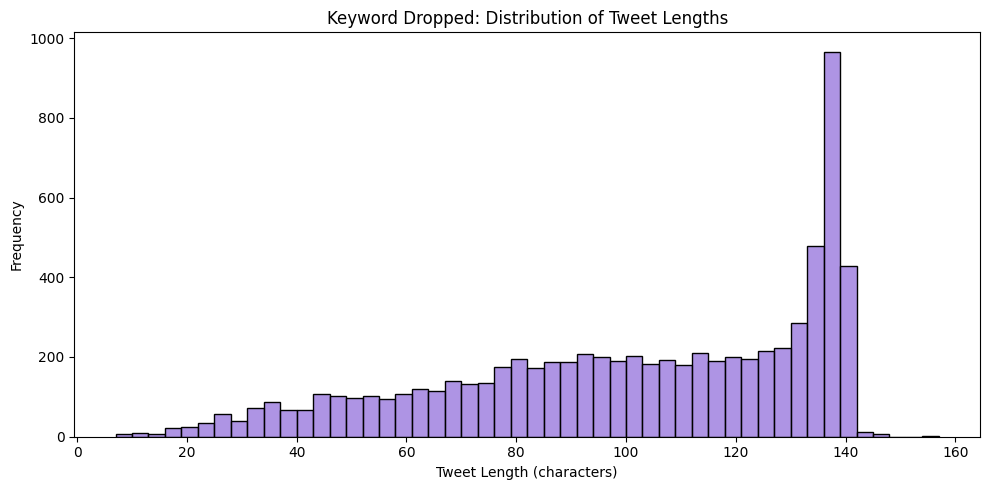

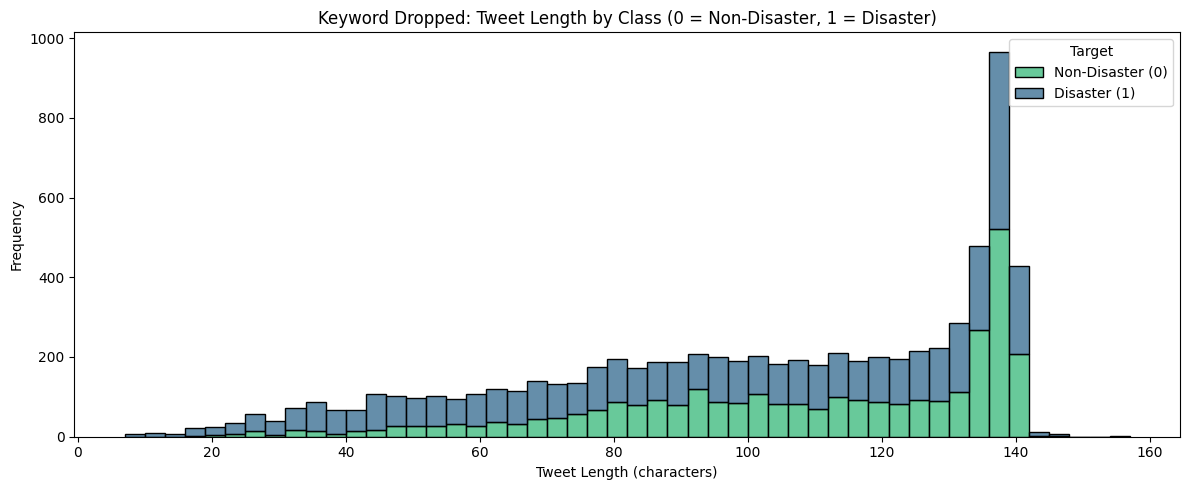

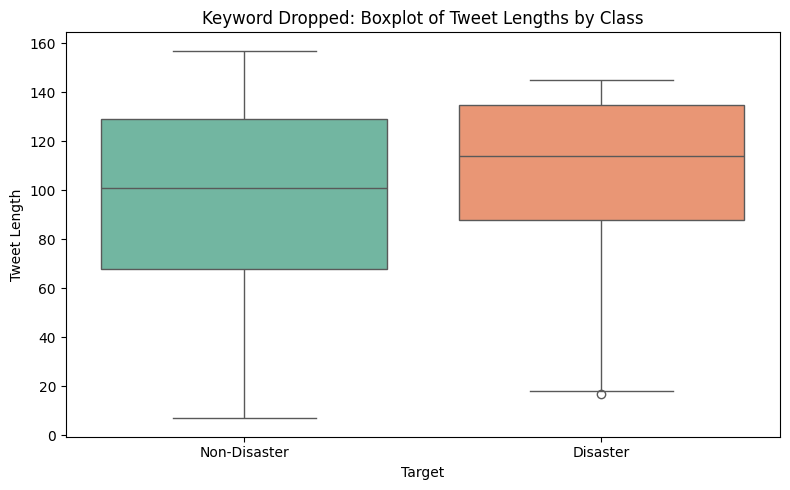

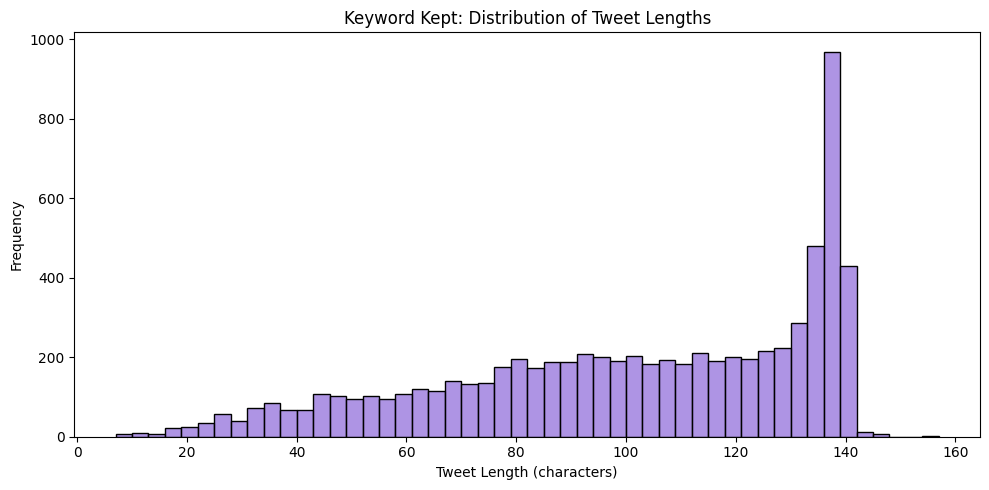

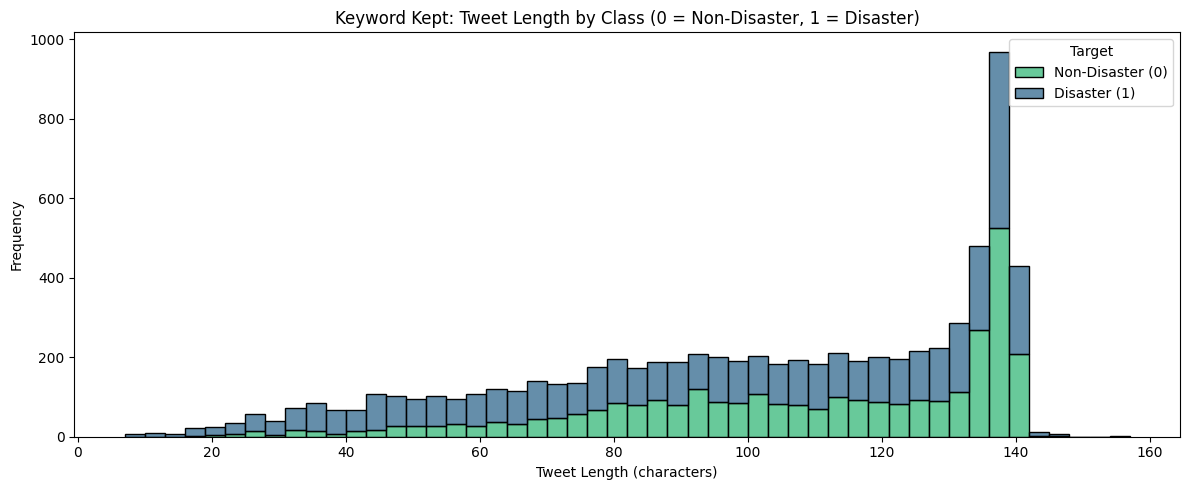

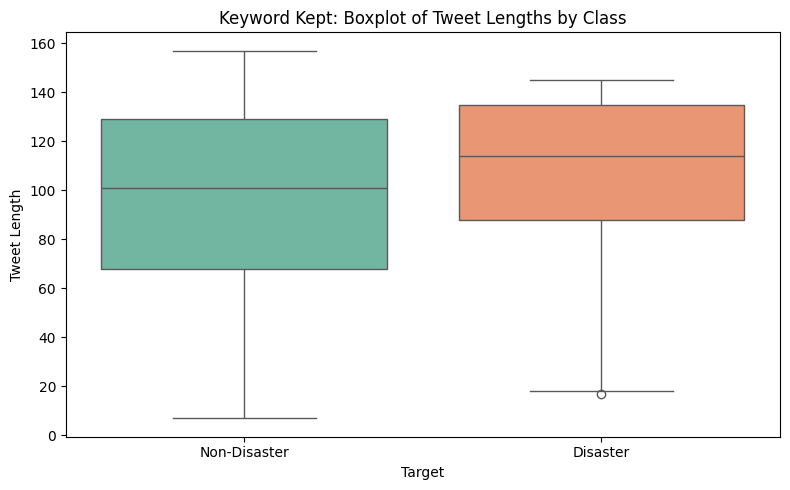

In [ ]:
plot_tweet_length_distribution(df_keyword_prepended, "Keyword Prepended")
plot_tweet_length_distribution(df_keyword_dropped, "Keyword Dropped")
plot_tweet_length_distribution(df_keyword_kept, "Keyword Kept")


### 3.4 🔖 Hashtag Analysis
Frequency distribution of hashtags per class


Bar charts for top hashtags in each target group


Shared hashtags across classes


Heatmap comparison


In [ ]:
def analyze_hashtags(df: pd.DataFrame, text_col: str = "text", target_col: str = "target", top_n: int = 15):
    """
    Analyzes and visualizes hashtag frequency across target classes.

    Parameters:
    -----------
    df : pd.DataFrame
        Input DataFrame containing tweet text and binary target labels.

    text_col : str, default="text"
        Name of the column containing the tweet text.

    target_col : str, default="target"
        Name of the column containing binary labels (0 or 1).

    top_n : int, default=15
        Number of top hashtags to visualize for each class.

    Returns:
    --------
    Tuple[pd.Series, pd.Series, pd.DataFrame]
        - Hashtag counts for target = 1
        - Hashtag counts for target = 0
        - Common hashtags DataFrame with side-by-side counts
    """
    from collections import Counter
    import matplotlib.pyplot as plt
    import seaborn as sns
    import re

    counter_1 = Counter()
    counter_0 = Counter()
    hashtag_pattern = re.compile(r"#\w+")

    for text, target in zip(df[text_col], df[target_col]):
        hashtags = hashtag_pattern.findall(str(text).lower())
        if target == 1:
            counter_1.update(hashtags)
        elif target == 0:
            counter_0.update(hashtags)

    hashtags_1 = pd.Series(counter_1).sort_values(ascending=False)
    hashtags_0 = pd.Series(counter_0).sort_values(ascending=False)

    # Plotting
    viridis = sns.color_palette("viridis", as_cmap=True)
    color1 = viridis(0.3)
    color2 = viridis(0.8)

    plt.figure(figsize=(10, 5))
    hashtags_1.head(top_n).plot(kind="bar", color=color2)
    plt.title("Top Hashtags (Disaster Tweets)")
    plt.xlabel("Hashtag")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    hashtags_0.head(top_n).plot(kind="bar", color=color1)
    plt.title("Top Hashtags (Non-Disaster Tweets)")
    plt.xlabel("Hashtag")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Shared hashtags
    common_tags = hashtags_1.index.intersection(hashtags_0.index)
    df_common = pd.DataFrame({
        "Disaster": hashtags_1.loc[common_tags],
        "Non-Disaster": hashtags_0.loc[common_tags]
    })

    df_common["total"] = df_common.sum(axis=1)
    df_common = df_common.sort_values("total", ascending=False).head(top_n)

    plt.figure(figsize=(8, 6))
    sns.heatmap(df_common[["Disaster", "Non-Disaster"]], annot=True, cmap="viridis", fmt=".0f")
    plt.title("Top Shared Hashtags: Heatmap Comparison")
    plt.ylabel("Hashtag")
    plt.xlabel("Target Class")
    plt.tight_layout()
    plt.show()

    # ✅ Print total hashtag counts
    print(f"Total hashtags in target=1 (Disaster): {sum(counter_1.values())}")
    print(f"Total hashtags in target=0 (Non-Disaster): {sum(counter_0.values())}")

    return hashtags_1, hashtags_0, df_common


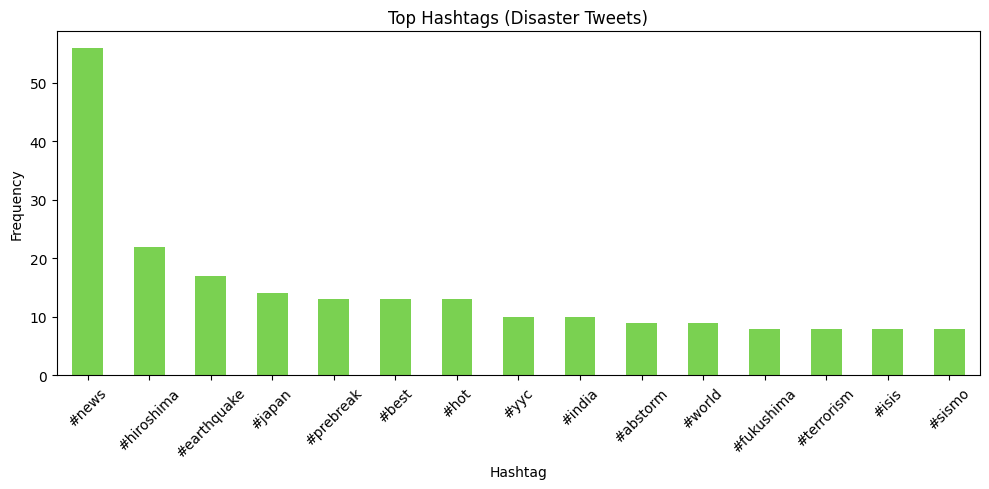

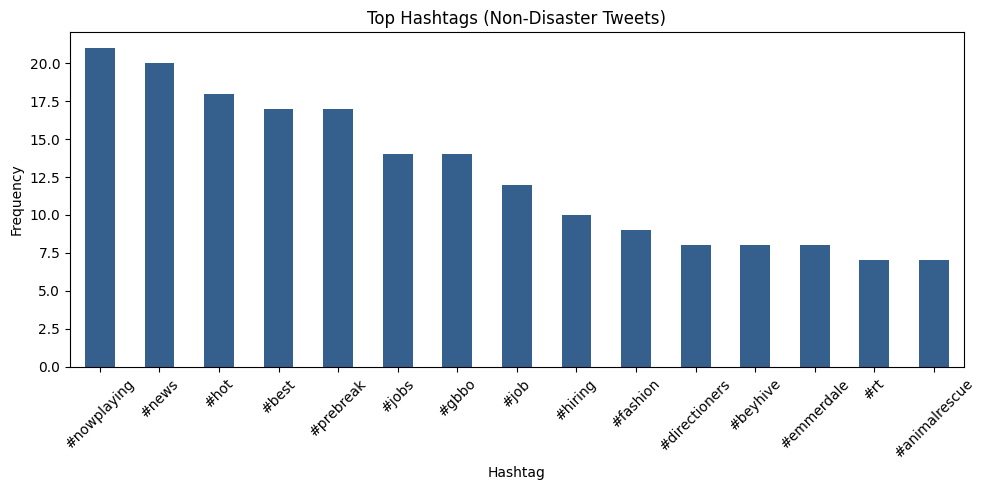

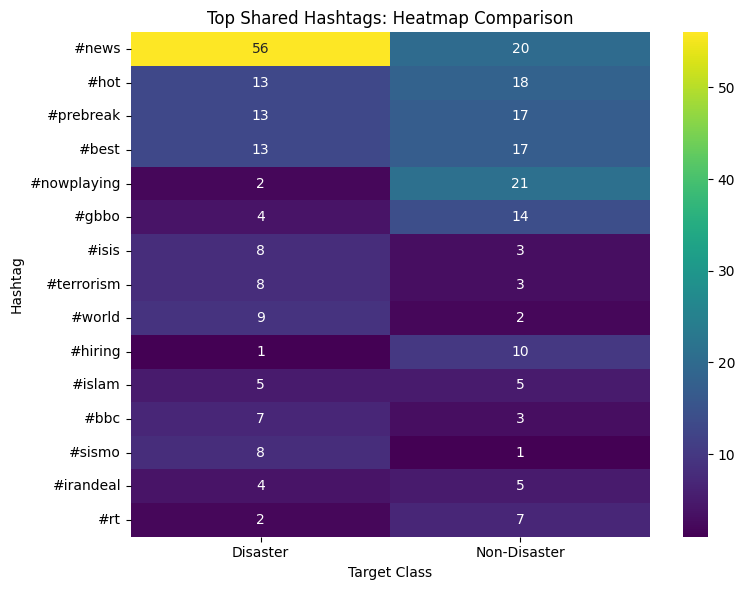

Total hashtags in target=1 (Disaster): 1563
Total hashtags in target=0 (Non-Disaster): 1643


In [ ]:
# Run hashtag analysis on all dataset variations
# hashtags_prepended_1, hashtags_prepended_0, common_hashtags_prepended = analyze_hashtags(df_keyword_prepended)
# hashtags_dropped_1, hashtags_dropped_0, common_hashtags_dropped = analyze_hashtags(df_keyword_dropped)
hashtags_kept_1, hashtags_kept_0, common_hashtags_kept = analyze_hashtags(df_keyword_kept)


### 3.5 👥 Mention (@) Analysis
Frequency of @mentions by class


Top mentions visualized


Comments on usage trends


In [ ]:
def analyze_mentions(df, dataset_label="Dataset"):
    """
    Analyze and visualize @mention usage in tweets, grouped by target class.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing 'text' and 'target' columns.
    dataset_label : str
        Label used in plot titles to distinguish datasets.

    Returns:
    --------
    None (displays plots and summary stats)
    """
    counter_1 = Counter()
    counter_0 = Counter()

    # Compile pattern for mentions
    mention_pattern = re.compile(r"@\w+")

    for text, target in zip(df["text"], df["target"]):
        mentions = mention_pattern.findall(str(text).lower())
        for mention in mentions:
            if target == 1:
                counter_1[mention] += 1
            else:
                counter_0[mention] += 1

    mentions_target1 = pd.Series(counter_1)
    mentions_target0 = pd.Series(counter_0)

    top_mentions_target1 = mentions_target1.sort_values(ascending=False).head(15)
    top_mentions_target0 = mentions_target0.sort_values(ascending=False).head(15)

    max_count = max(top_mentions_target1.max(), top_mentions_target0.max())
    viridis = sns.color_palette("viridis", as_cmap=True)
    color1 = viridis(0.3)
    color2 = viridis(0.7)

    # Plot for target = 1
    plt.figure(figsize=(10, 6))
    top_mentions_target1.plot(kind="bar", color=color1)
    plt.title(f"Top 15 Mentions in Disaster Tweets (Target=1) - {dataset_label}")
    plt.xlabel("Mention")
    plt.ylabel("Count")
    plt.ylim(0, max_count)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # Plot for target = 0
    plt.figure(figsize=(10, 6))
    top_mentions_target0.plot(kind="bar", color=color2)
    plt.title(f"Top 15 Mentions in Non-Disaster Tweets (Target=0) - {dataset_label}")
    plt.xlabel("Mention")
    plt.ylabel("Count")
    plt.ylim(0, max_count)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # ✅ Print summary stats
    total_mentions_1 = sum(counter_1.values())
    total_mentions_0 = sum(counter_0.values())
    print(f"Total @mentions in target=1 (Disaster): {total_mentions_1}")
    print(f"Total @mentions in target=0 (Non-Disaster): {total_mentions_0}")


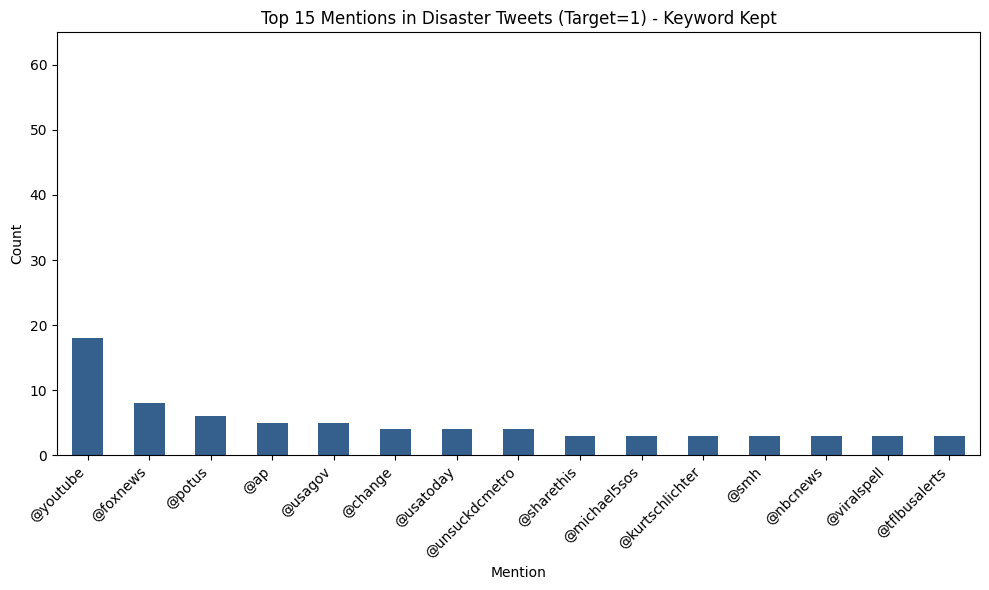

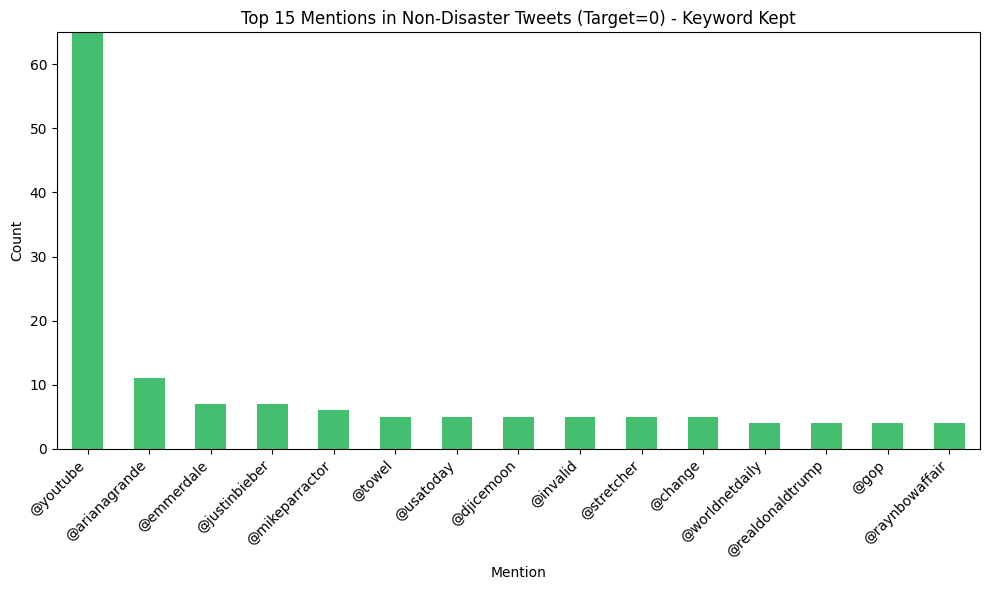

Total @mentions in target=1 (Disaster): 887
Total @mentions in target=0 (Non-Disaster): 1819


In [ ]:
# # 🔍 Analyze mentions in the dataset with keyword prepended to text
# analyze_mentions(df_keyword_prepended, dataset_label="Keyword Prepended")

# # 🔍 Analyze mentions in the dataset with keyword dropped
# analyze_mentions(df_keyword_dropped, dataset_label="Keyword Dropped")

# 🔍 Analyze mentions in the dataset with keyword kept
analyze_mentions(df_keyword_kept, dataset_label="Keyword Kept")

### 3.6 🔗 URL Analysis
Frequency and examples of URLs


Distribution by target class


Bar chart of top URLs


In [ ]:
def analyze_urls(df: pd.DataFrame):
    """
    Analyzes URL usage in tweets, visualizing frequency by target class and top URLs.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with at least 'text' and 'target' columns.
    """

    # Initialize counters for each target
    url_counter_1 = Counter()
    url_counter_0 = Counter()

    # URL regex
    url_pattern = re.compile(r"(https?://\S+|www\.\S+)")

    # Collect URLs by target
    for text, target in zip(df['text'], df['target']):
        urls = url_pattern.findall(str(text).lower())
        for url in urls:
            if target == 1:
                url_counter_1[url] += 1
            elif target == 0:
                url_counter_0[url] += 1

    # Convert to DataFrames
    df_urls_1 = pd.Series(url_counter_1).sort_values(ascending=False).head(15)
    df_urls_0 = pd.Series(url_counter_0).sort_values(ascending=False).head(15)

    # Get unified y-axis limit
    max_count = max(df_urls_1.max(), df_urls_0.max())

    # Define shared color palette
    viridis = sns.color_palette("viridis", as_cmap=True)
    color1 = viridis(0.3)
    color2 = viridis(0.8)

    # Plot target = 1
    plt.figure(figsize=(10, 5))
    df_urls_1.plot(kind='bar', color=color1)
    plt.title('Top 15 URLs in Disaster-Related Tweets (target = 1)')
    plt.xlabel('URL')
    plt.ylabel('Count')
    plt.ylim(0, max_count)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Plot target = 0
    plt.figure(figsize=(10, 5))
    df_urls_0.plot(kind='bar', color=color2)
    plt.title('Top 15 URLs in Non-Disaster Tweets (target = 0)')
    plt.xlabel('URL')
    plt.ylabel('Count')
    plt.ylim(0, max_count)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Summary stats
    total_urls_1 = sum(url_counter_1.values())
    total_urls_0 = sum(url_counter_0.values())
    print(f"Total URLs in target=1 (Disaster): {total_urls_1}")
    print(f"Total URLs in target=0 (Non-Disaster): {total_urls_0}")


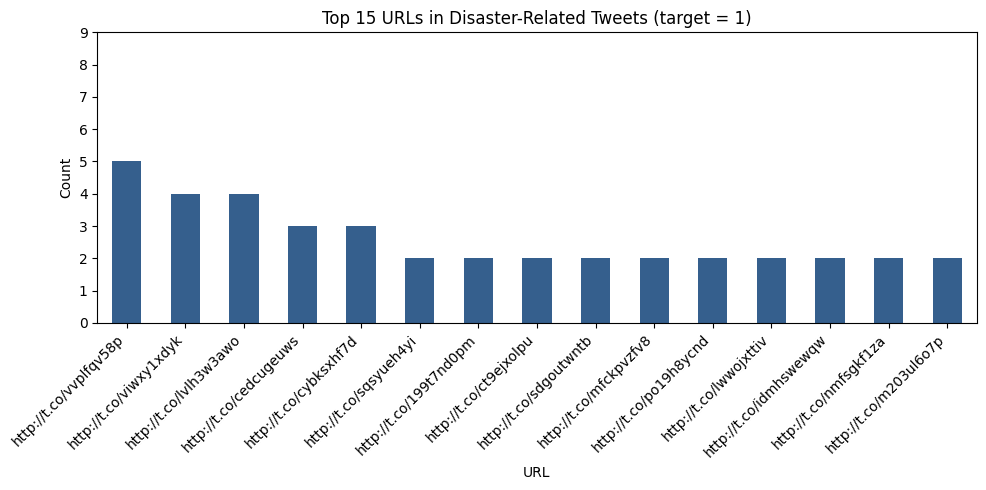

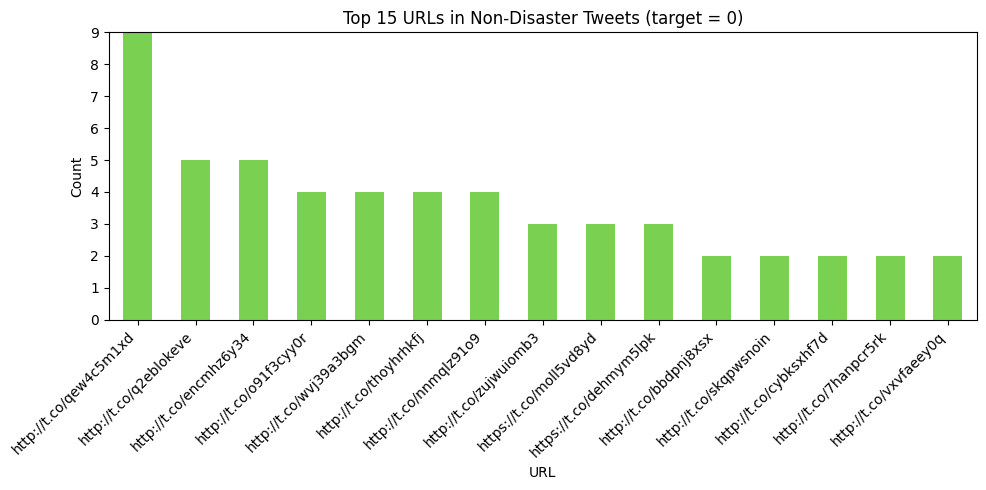

Total URLs in target=1 (Disaster): 2482
Total URLs in target=0 (Non-Disaster): 2192


In [ ]:
# # 🔗 URL Analysis for each cleaned dataset
# analyze_urls(df_keyword_prepended)
# analyze_urls(df_keyword_dropped)
analyze_urls(df_keyword_kept)

### 3.7 😅 Detect Rows with Emojis or ASCII Emoticons
Detect and count emojis


Analyze distribution by class


Visualize presence of common special characters (e.g., ‘!’, ‘#’, ‘:’, etc.)



In [ ]:
def analyze_emojis_and_emoticons(df, text_col="text", target_col="target", dataset_label="Dataset"):
    """
    Detects emoji and emoticon usage in text and visualizes distribution by target class.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the tweet text and binary labels.

    text_col : str, default="text"
        Name of the column containing tweet text.

    target_col : str, default="target"
        Name of the column containing target class.

    dataset_label : str
        Label for titles/plots to distinguish datasets.

    Returns:
    --------
    None
    """
    import re
    from collections import Counter

    emoji_pattern = re.compile("["
        "\U0001F600-\U0001F64F"
        "\U0001F300-\U0001F5FF"
        "\U0001F680-\U0001F6FF"
        "\U0001F700-\U0001F77F"
        "\U0001F780-\U0001F7FF"
        "\U0001F800-\U0001F8FF"
        "\U0001F900-\U0001F9FF"
        "\U0001FA00-\U0001FA6F"
        "\U0001FA70-\U0001FAFF"
        "\U00002702-\U000027B0"
        "\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)

    emoticon_pattern = re.compile(r"[:;=xX8][\-^oO']?[\)D\(\]/\\OpP]")

    def contains_special(text):
        text = str(text)
        return bool(emoji_pattern.search(text)) or bool(emoticon_pattern.search(text))

    df["has_special"] = df[text_col].apply(contains_special)

    # Count by target
    counts = df.groupby(target_col)["has_special"].value_counts().unstack().fillna(0)
    counts.index = counts.index.map({0: "Non-Disaster", 1: "Disaster"})

    # Plot
    plt.figure(figsize=(6, 4))
    counts.plot(kind="bar", stacked=True, colormap="viridis")
    plt.title(f"Emoji/Emoticon Usage by Target - {dataset_label}")
    plt.ylabel("Tweet Count")
    plt.xlabel("Target")
    plt.xticks(rotation=0)
    plt.legend(["No Emoji/Emoticon", "Has Emoji/Emoticon"], title="Contains")
    plt.tight_layout()
    plt.show()

    # Print counts
    print(f"Total tweets with emoji/emoticon: {df['has_special'].sum()} out of {len(df)} ({df['has_special'].mean()*100:.2f}%)\n")


<Figure size 600x400 with 0 Axes>

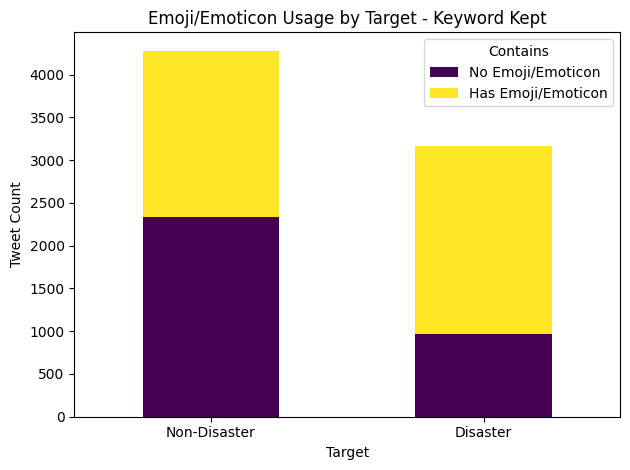

Total tweets with emoji/emoticon: 4145 out of 7444 (55.68%)



In [ ]:
# analyze_emojis_and_emoticons(df_keyword_prepended, dataset_label="Keyword Prepended")
# analyze_emojis_and_emoticons(df_keyword_dropped, dataset_label="Keyword Dropped")
analyze_emojis_and_emoticons(df_keyword_kept, dataset_label="Keyword Kept")


### 3.8 🧵 Sample Tweet Inspection
Display example tweets by class


Include edge cases (very short, very long, only special characters, etc.)


In [ ]:
def inspect_sample_tweets(df: pd.DataFrame, dataset_label: str = "Dataset", n_samples: int = 3):
    """
    Display random and edge case tweet examples by target class.

    Parameters:
    -----------
    df : pd.DataFrame
        Input DataFrame containing 'text' and 'target' columns.

    dataset_label : str
        A label for the dataset to include in printed headers.

    n_samples : int, default=3
        Number of random tweets to sample from each class.

    Returns:
    --------
    None
    """
    print(f"\n📄 Sample Tweets from {dataset_label}:\n")

    for label, name in [(0, "Non-Disaster"), (1, "Disaster")]:
        print(f"--- {name} Tweets ---\n")
        samples = df[df["target"] == label]["text"].sample(n=n_samples, random_state=42)
        for idx, tweet in enumerate(samples, 1):
            print(f"{idx}. {tweet}\n")

    print("\n🔎 Edge Case Examples:\n")

    # Shortest tweet
    df["text_length"] = df["text"].apply(len)
    print(f"🧵 Shortest Tweet ({df['text_length'].min()} chars):\n{df.loc[df['text_length'].idxmin(), 'text']}\n")

    # Longest tweet
    print(f"🧵 Longest Tweet ({df['text_length'].max()} chars):\n{df.loc[df['text_length'].idxmax(), 'text']}\n")

    # Only special characters
    special_only = df[df["text"].str.match(r"^[^\w\s]+$", na=False)]
    if not special_only.empty:
        print("🧵 Tweet with only special characters:\n", special_only.iloc[0]["text"], "\n")

    # Only whitespace or empty
    whitespace_only = df[df["text"].str.strip() == ""]
    if not whitespace_only.empty:
        print("🧵 Empty or whitespace-only tweet:\n", whitespace_only.iloc[0]["text"], "\n")

    # Only emoji or emoticon
    emoji_emoticon_only = df[df["text"].apply(lambda x: bool(re.fullmatch(r"[\W\d_]+", str(x).strip())))]
    if not emoji_emoticon_only.empty:
        print("🧵 Emoji/Emoticon-only tweet:\n", emoji_emoticon_only.iloc[0]["text"], "\n")

    # Drop helper column
    df.drop(columns="text_length", inplace=True)


In [ ]:
# inspect_sample_tweets(df_keyword_prepended, dataset_label="Keyword Prepended")
inspect_sample_tweets(df_keyword_dropped, dataset_label="Keyword Dropped")
# inspect_sample_tweets(df_keyword_kept, dataset_label="Keyword Kept")



📄 Sample Tweets from Keyword Dropped:

--- Non-Disaster Tweets ---

1. Blood Group  A +ve is associated with Gastric Carcinoma says text book...Another fragile gene in my body....

2. Morgan Silver Dollar 1921 P CH Gem Bu PL Blazing MS++++++ Satin Rare Proof Like! - Full re_ http://t.co/99MbyFl3Id http://t.co/4ddMTguZzS

diarrhea hurricane

--- Disaster Tweets ---

1. Wreckage 'Conclusively Confirmed' as From MH370: Malaysia PM: Investigators and the families of those who were... http://t.co/KuKmAL605a

2. Grace: here are damage levels USA style.. #Taiwan #China #world hurricane/typhoon ratings/categories defined again http://t.co/OdYdT9QPk1

3. The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/RlPTtkBG4W


🔎 Edge Case Examples:

🧵 Shortest Tweet (7 chars):
Crushed

🧵 Longest Tweet (157 chars):
when you're taking a shower and someone flushes the toilet and you have .1 second to GTFO or you get burned??????????????????????????????????????????????????




---

## 4. 🔄 Text Preprocessing Variants <a name="preprocessing-variants"></a>

We apply multiple preprocessing strategies to generate diverse versions of the tweet dataset for model comparison. Each variant is saved independently and labeled for later use.

### ✅ Preprocessing Base Versions
Each variant is generated from three base datasets:
- **Keyword Prepended** – `df_keyword_prepended`
- **Keyword Dropped** – `df_keyword_dropped`
- **Keyword Kept** – `df_keyword_kept`

### 🧪 Variant Descriptions

| Variant | Description |
|--------|-------------|
| **v1_basic_clean** | Lowercased, punctuation and stopwords removed |
| **v2_no_emojis_mentions** | Basic clean + remove emojis and @mentions |
| **v3_lemmatized** | Lemmatization applied |
| **v4_stemmed** | Stemming applied |
| **v5_lemma_stem** | Lemmatization + stemming |
| **v6_custom_stopwords** | Lemmatization + extended stopword list |
| **v7_lowercase_words_only** | Keep only lowercase alphabetic tokens |
| **v8_keep_hashtags** | Lemmatized but retains hashtags |
| **v9_minimal_processing** | No stopword, URL, emoji, or mention removal (baseline variant) |

Each variant is stored in the `final_processed/` directory with a filename structure like:

```
final_processed/{df_label}_v{variant_number}_{variant_name}.csv
```

**Examples:**
- `final_processed/prepended_v3_lemmatized.csv`
- `final_processed/dropped_v6_custom_stopwords.csv`

---


In [ ]:
# Setup
stop_words = set(stopwords.words('english'))
extra_stopwords = [
    "get", "he", "that", "didnt", "doesnt", "dont", "isnt", "ive", "know",
    "least", "let", "like","may", "much", "must", "never", "one", "other", "rt",
    "said", "see", "seem", "she", "take", "thank", "there", "though", "still",
    "us", "use", "want", "wasnt", "way", "well", "what", "without", "wont",
    "would", "yet", "your", "im"
]
stop_words.update(extra_stopwords)
stop_words.update(string.punctuation)

lemmatizer = WordNetLemmatizer()
stemmer = nltk.PorterStemmer()
tweet_tokenizer = TweetTokenizer()

def preprocess_text(
    text,
    lowercase=True,
    remove_stopwords=True,
    remove_emojis=True,
    remove_mentions=True,
    remove_urls=True,
    remove_numbers=True,
    lemmatize=False,
    stem=False,
    keep_hashtags=False,
    tokenizer=tweet_tokenizer
):
    try:
        if not isinstance(text, str) or text.strip() == "":
            return ""

        if lowercase:
            text = text.lower()

        if remove_emojis:
            emoji_pattern = re.compile("["
                "\U0001F600-\U0001F64F"
                "\U0001F300-\U0001F5FF"
                "\U0001F680-\U0001F6FF"
                "\U0001F700-\U0001F77F"
                "\U0001F780-\U0001F7FF"
                "\U0001F800-\U0001F8FF"
                "\U0001F900-\U0001F9FF"
                "\U0001FA00-\U0001FA6F"
                "\U0001FA70-\U0001FAFF"
                "\U00002702-\U000027B0"
                "\U000024C2-\U0001F251"
                "]+", flags=re.UNICODE)
            text = emoji_pattern.sub('', text)

        if remove_mentions:
            text = re.sub(r"@\w+", "", text)

        if remove_urls:
            text = re.sub(r"http\S+|www\.\S+", "", text)

        if not keep_hashtags:
            text = re.sub(r"#", "", text)

        if remove_numbers:
            text = re.sub(r'\S*\d\S*', '', text)

        text = re.sub(r"[^\w\s]", "", text)
        tokens = tokenizer.tokenize(text)

        if remove_stopwords:
            tokens = [t for t in tokens if t not in stop_words]

        if lemmatize:
            tokens = [lemmatizer.lemmatize(t) for t in tokens]

        if stem:
            tokens = [stemmer.stem(t) for t in tokens]

        return " ".join(tokens)

    except Exception as e:
        print(f"[WARNING] Preprocessing failed for: {repr(text)}\n→ {e}")
        return ""

In [ ]:
def generate_text_variants(df: pd.DataFrame, df_label: str = "prepended", output_dir: str = "processed"):
    """
    Generates and saves multiple preprocessed versions of a tweet dataset.

    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame containing a 'text' column.

    df_label : str, default="prepended"
        Label prefix to use in saved filenames (e.g., "prepended_v1_basic_clean.csv").

    output_dir : str, default="processed"
        Directory to save the processed datasets.

    Returns:
    --------
    None
    """

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    variants = {
        "v1_basic_clean": {"remove_emojis": False, "remove_mentions": False},
        "v2_no_emojis_mentions": {"remove_emojis": True, "remove_mentions": True},
        "v3_lemmatized": {"lemmatize": True},
        "v4_stemmed": {"stem": True},
        "v5_lemma_stem": {"lemmatize": True, "stem": True},
        "v6_custom_stopwords": {"lemmatize": True},
        "v7_lowercase_words_only": {"remove_numbers": True},
        "v8_keep_hashtags": {"lemmatize": True, "keep_hashtags": True},
        "v9_minimal_processing": {
            "remove_stopwords": False,
            "remove_emojis": False,
            "remove_mentions": False,
            "remove_urls": False,
            "lemmatize": False,
            "stem": False
        }
    }

    for name, options in variants.items():
        variant_df = df.copy()
        variant_df["processed_text"] = variant_df["text"].apply(lambda x: preprocess_text(x, **options))
        save_path = f"{output_dir}/{df_label}_{name}.csv"
        variant_df.to_csv(save_path, index=False)
        print(f"✅ Saved: {save_path}")


In [ ]:
generate_text_variants(df_keyword_prepended, df_label="prepended", output_dir="final_processed")
generate_text_variants(df_keyword_dropped, df_label="dropped", output_dir="final_processed")
generate_text_variants(df_keyword_kept, df_label="kept", output_dir="final_processed")

✅ Saved: final_processed/prepended_v1_basic_clean.csv
✅ Saved: final_processed/prepended_v2_no_emojis_mentions.csv
✅ Saved: final_processed/prepended_v3_lemmatized.csv
✅ Saved: final_processed/prepended_v4_stemmed.csv
✅ Saved: final_processed/prepended_v5_lemma_stem.csv
✅ Saved: final_processed/prepended_v6_custom_stopwords.csv
✅ Saved: final_processed/prepended_v7_lowercase_words_only.csv
✅ Saved: final_processed/prepended_v8_keep_hashtags.csv
✅ Saved: final_processed/prepended_v9_minimal_processing.csv
✅ Saved: final_processed/dropped_v1_basic_clean.csv
✅ Saved: final_processed/dropped_v2_no_emojis_mentions.csv
✅ Saved: final_processed/dropped_v3_lemmatized.csv
✅ Saved: final_processed/dropped_v4_stemmed.csv
✅ Saved: final_processed/dropped_v5_lemma_stem.csv
✅ Saved: final_processed/dropped_v6_custom_stopwords.csv
✅ Saved: final_processed/dropped_v7_lowercase_words_only.csv
✅ Saved: final_processed/dropped_v8_keep_hashtags.csv
✅ Saved: final_processed/dropped_v9_minimal_processing.cs

In [ ]:
def check_nans_in_processed_verbose(folder="final_processed", column="processed_text", show_rows=True):
    """
    Check all processed CSV files for NaN values in a specific column.
    Optionally print out the rows containing NaNs.

    Parameters:
    -----------
    folder : str
        Folder path where processed CSVs are stored.

    column : str
        Column to check for NaN values.

    show_rows : bool
        If True, prints rows with NaNs for inspection.

    Returns:
    --------
    dict
        Summary of files with NaN counts.
    dict
        Dictionary of file → DataFrame of rows with NaNs.
    """
    nan_summary = {}
    nan_rows = {}

    for file in os.listdir(folder):
        if file.endswith(".csv"):
            path = os.path.join(folder, file)
            df = pd.read_csv(path)

            if column in df.columns:
                nan_mask = df[column].isna()
                nan_count = nan_mask.sum()

                if nan_count > 0:
                    nan_summary[file] = nan_count
                    nan_df = df[nan_mask]
                    nan_rows[file] = nan_df

                    if show_rows:
                        print(f"\n📄 File: {file} — {nan_count} NaNs")
                        print(nan_df[[column, 'text']].head(nan_count))  # shows NaN and original text side-by-side

    return nan_summary, nan_rows


---

## 5. 🌥️ Word Clouds & Frequency Comparison <a name="wordclouds"></a>

This section generates word clouds and frequency bar charts for each preprocessed dataset to visualize word usage patterns. For each variant, we analyze:

- **Overall Word Cloud**: Most frequent words across all tweets.
- **Class-Wise Word Clouds**: Separate word clouds for disaster (`target = 1`) and non-disaster (`target = 0`) tweets.
- **Top Word Frequency Bar Charts**: Comparing high-frequency tokens across classes.

These visualizations help identify which preprocessing strategies retain the most meaningful features and how class distinctions are reflected in word usage.

---


In [ ]:
def load_processed_datasets(folder_path="final_processed"):
    """
    Load all processed datasets from a folder into a dictionary.

    Returns:
    --------
    dict: {filename_without_ext: DataFrame}
    """
    datasets = {}
    for fname in os.listdir(folder_path):
        if fname.endswith(".csv"):
            name = fname.replace(".csv", "")
            datasets[name] = pd.read_csv(os.path.join(folder_path, fname))
    return datasets


In [ ]:
def save_word_stats(df, dataset_label, text_col="processed_text", target_col="target", top_n=20, output_dir="wordclouds"):
    """
    Generate and save word clouds and frequency bar plots to disk.

    Parameters:
    -----------
    df : pd.DataFrame
        The processed dataset containing at least 'processed_text' and 'target' columns.
    dataset_label : str
        A unique label identifying this dataset (used as the folder name).
    text_col : str
        Column name containing processed tweet text.
    target_col : str
        Column containing binary labels (0 or 1).
    top_n : int
        Number of top words to show in bar plots.
    output_dir : str
        Parent directory to save word clouds and plots.
    """
    subdir = os.path.join(output_dir, dataset_label)
    os.makedirs(subdir, exist_ok=True)

    # Frequency counts
    tokens_all = " ".join(df[text_col].astype(str)).split()
    tokens_0 = " ".join(df[df[target_col] == 0][text_col].astype(str)).split()
    tokens_1 = " ".join(df[df[target_col] == 1][text_col].astype(str)).split()

    counter_all = Counter(tokens_all)
    counter_0 = Counter(tokens_0)
    counter_1 = Counter(tokens_1)

    viridis = sns.color_palette("viridis", as_cmap=True)

    # Word Cloud Generation
    for counter, label in zip(
        [counter_all, counter_0, counter_1],
        ["all", "target0", "target1"]
    ):
        wc = WordCloud(width=800, height=400, background_color="white", colormap="viridis", max_words=1000)
        wc.generate_from_frequencies(counter)
        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"{label.capitalize()} - {dataset_label}")
        plt.tight_layout()
        path = os.path.join(subdir, f"wordcloud_{label}.png")
        plt.savefig(path)
        plt.close()

    # Frequency Bar Charts
    for counter, label in zip([counter_0, counter_1], ["target0", "target1"]):
        top_words = counter.most_common(top_n)
        words, freqs = zip(*top_words)
        plt.figure(figsize=(12, 5))
        sns.barplot(x=list(words), y=list(freqs), palette="viridis")
        plt.title(f"Top {top_n} Words for {label} - {dataset_label}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        path = os.path.join(subdir, f"freqplot_{label}.png")
        plt.savefig(path)
        plt.close()

    print(f"Saved word cloud and frequency plots for: {dataset_label}")


In [ ]:
for file in os.listdir("final_processed"):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join("final_processed", file))
        label = file.replace(".csv", "")
        save_word_stats(df, dataset_label=label)


Saved word cloud and frequency plots for: prepended_v2_no_emojis_mentions
Saved word cloud and frequency plots for: dropped_v4_stemmed
Saved word cloud and frequency plots for: prepended_v8_keep_hashtags
Saved word cloud and frequency plots for: kept_v3_lemmatized
Saved word cloud and frequency plots for: kept_v5_lemma_stem
Saved word cloud and frequency plots for: kept_v2_no_emojis_mentions
Saved word cloud and frequency plots for: kept_v6_custom_stopwords
Saved word cloud and frequency plots for: kept_v9_minimal_processing
Saved word cloud and frequency plots for: dropped_v8_keep_hashtags
Saved word cloud and frequency plots for: prepended_v3_lemmatized
Saved word cloud and frequency plots for: dropped_v2_no_emojis_mentions
Saved word cloud and frequency plots for: dropped_v6_custom_stopwords
Saved word cloud and frequency plots for: kept_v8_keep_hashtags
Saved word cloud and frequency plots for: dropped_v3_lemmatized
Saved word cloud and frequency plots for: dropped_v7_lowercase_wor

---
## 7. 🤖 Modeling Pipeline <a name="modeling"></a>

This section runs classification models on each of the 27 processed datasets.
Each variant is passed through a consistent pipeline using TF-IDF + ML classifiers:

**Steps:**
- Split data into training and test sets
- Use pipelines for:
  - Multinomial Naive Bayes
  - Logistic Regression
  - Passive Aggressive Classifier
  - Support Vector Machine
- Evaluate using:
  - Accuracy
  - Precision
  - Recall
  - F1 Score
  - ROC AUC

Each model's performance is evaluated using cross-validation and on a held-out test set.

---

---

### 7.1 📂 Load Preprocessed Datasets  
Load all text-processed CSVs and prepare `(X, y)` pairs for modeling.

---

In [ ]:
def load_xy_datasets(folder_path="final_processed", text_col="processed_text", target_col="target"):
    """
    Load processed datasets and return (X, y) tuples for modeling.
    Drops rows with NaN values in either the text or target columns.

    Parameters:
    -----------
    folder_path : str
        Directory containing the processed CSV files.
    text_col : str
        Name of the column containing cleaned text.
    target_col : str
        Name of the column containing target labels.

    Returns:
    --------
    dict
        Dictionary mapping file names to (X, y) tuples.
    """
    xy_datasets = {}
    nan_report = {}

    for fname in os.listdir(folder_path):
        if fname.endswith(".csv"):
            path = os.path.join(folder_path, fname)
            name = fname.replace(".csv", "")
            df = pd.read_csv(path)

            # Count initial NaNs
            nans_before = df[[text_col, target_col]].isna().sum().sum()

            # Drop NaNs in either column
            df = df.dropna(subset=[text_col, target_col]).reset_index(drop=True)

            nans_after = df[[text_col, target_col]].isna().sum().sum()
            if nans_before > 0:
                nan_report[name] = nans_before

            if text_col in df.columns and target_col in df.columns:
                xy_datasets[name] = (df[text_col], df[target_col])

    print(f"\n📥 Loaded {len(xy_datasets)} datasets.")

    if nan_report:
        print("\n⚠️ Datasets with NaNs (before cleaning):")
        for name, count in nan_report.items():
            print(f" - {name}: {count} NaNs removed")

    return xy_datasets



---

### 7.2 🔧 Define Classifier Pipelines  
Set up pipelines for each classifier with TF-IDF + model combinations.

---

In [ ]:
# Common TF-IDF config for all models
tfidf = TfidfVectorizer(
    stop_words='english',
    max_df=0.8,
    ngram_range=(1, 3)
)

# Caleb - converting Pandas dataframe to HuggingFace Dataset
def convert_to_hf(dataset):
    dataset.drop(columns=['text', 'text_length', 'length'], inplace=True)
    dataset.rename(columns={'processed_text':'text', 'target':'label'}, inplace=True)
    dataset = dataset[["text", "label"]].copy()
    dataset["text"] = dataset["text"].astype(str) # Force all entries to be strings
    dataset = Dataset.from_pandas(dataset)

# Define pipelines
pipelines = {
    'MultinomialNB': Pipeline([
        ('tfidf', tfidf),
        ('clf', MultinomialNB())
    ]),
    'LogisticRegression': Pipeline([
        ('tfidf', tfidf),
        ('clf', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    'PassiveAggressive': Pipeline([
        ('tfidf', tfidf),
        ('clf', PassiveAggressiveClassifier(max_iter=1000, random_state=42))
    ]),
    'SVM': Pipeline([
        ('tfidf', tfidf),
        ('clf', SVC(kernel='linear', C=1.0, probability=True, random_state=42))
    ]),
    'KNN': Pipeline([
        ('tfidf', tfidf),
        ('clf', KNeighborsClassifier(n_neighbors=5))
    ]),
    'NeuralNetwork': Pipeline([
        ('tfidf', tfidf),
        ('clf', MLPClassifier(hidden_layer_sizes=(50,), max_iter=300, verbose=True,
        random_state=42))
    ]) #, Insert commma here after defining BERT pipeline
    # 'BERT': Pipeline([   # Caleb - defining BERT pipeline
    #     ('')
    # ])
}

---

### 7.3 🧪 Train/Test Split & Cross-Validation  
Split each dataset into training and test sets (80/20), and apply Stratified K-Fold cross-validation.

---

In [ ]:
def plot_learning_curve(estimator, title, X, y, cv, scoring='accuracy', n_jobs=-1, save_path=None):

    # Use viridis colormap to get consistent, soft shades
    viridis = cm.get_cmap('viridis')
    train_color = to_hex(viridis(0.25))  # bluish-teal
    test_color = to_hex(viridis(0.65))   # greenish

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=np.linspace(0.1, 1.0, 10)
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(facecolor='white')
    plt.title(title)
    plt.xlabel("Training Examples")
    plt.ylabel(scoring.capitalize())
    plt.grid(alpha=0.3)

    # Soft shading
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color=train_color)
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color=test_color)

    plt.plot(train_sizes, train_scores_mean, 'o-', color=train_color, label="Training Score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color=test_color, label="Validation Score")

    plt.legend(loc="best")
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

In [ ]:
def evaluate_models(xy_datasets, pipelines, cv_folds=5, random_state=42, output_dir="performance_metrics"):

    results = []

    viridis = cm.get_cmap('viridis', 256)
    viridis_light = ListedColormap(viridis(np.linspace(0.2, 0.8)))  # focus on mid-range


    for dataset_name, (X, y) in xy_datasets.items():
        print(f"\n📦 Dataset: {dataset_name} ({len(X)} samples)")

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=random_state
        )

        for model_name, pipeline in pipelines.items():
            print(f"  🔍 Evaluating: {model_name}")
            combo_name = f"{dataset_name}_{model_name}"
            save_dir = os.path.join(output_dir, combo_name)
            os.makedirs(save_dir, exist_ok=True)

            cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
            acc = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy').mean()
            prec = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='precision').mean()
            rec = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='recall').mean()
            f1 = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1').mean()

            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)

            try:
                if hasattr(pipeline.named_steps['clf'], 'predict_proba'):
                    y_scores = pipeline.predict_proba(X_test)[:, 1]
                else:
                    y_scores = pipeline.decision_function(X_test)
                roc = roc_auc_score(y_test, y_scores)
            except Exception:
                roc = np.nan
                y_scores = None

            results.append({
                'Dataset': dataset_name,
                'Model': model_name,
                'Accuracy': acc,
                'Precision': prec,
                'Recall': rec,
                'F1 Score': f1,
                'ROC AUC': roc
            })

            # ROC Curve
            if y_scores is not None:
                fpr, tpr, _ = roc_curve(y_test, y_scores)
                plt.figure()
                plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc:.2f})', color=to_hex(viridis(0.6)))
                plt.plot([0, 1], [0, 1], 'k--', alpha=0.4)
                plt.grid(alpha=0.3)
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title(f'ROC Curve — {model_name} on {dataset_name}')
                plt.legend(loc='lower right')
                plt.tight_layout()
                plt.savefig(os.path.join(save_dir, "roc_curve.png"))
                plt.close()

            # Confusion Matrix
            cmatrix = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(6, 5))
            sns.heatmap(
                cmatrix,
                annot=True,
                fmt='d',
                # cmap=sns.light_palette("seagreen", as_cmap=True),
                cmap=viridis_light,
                cbar=False,
                linewidths=0.5,
                linecolor='white',
                square=True,
                annot_kws={"size": 12},
                xticklabels=pipeline.classes_,
                yticklabels=pipeline.classes_
            )
            plt.title(f'Confusion Matrix — {model_name} on {dataset_name}')
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.tight_layout()
            plt.savefig(os.path.join(save_dir, "confusion_matrix.png"))
            plt.close()

            # Learning Curve
            print(f"📈 Plotting learning curve for {model_name} on {dataset_name}...")
            plot_learning_curve(
                pipeline,
                f"Learning Curve — {model_name} on {dataset_name}",
                X_train,
                y_train,
                cv=cv,
                save_path=os.path.join(save_dir, "learning_curve.png")
            )

    # Sort by F1 Score in descending order
    results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False).reset_index(drop=True)

    styled = results_df.style.highlight_max(axis=0, color='green').set_table_styles([
        {'selector': 'th', 'props': [('font-size', '14px'), ('color', 'black'), ('background-color', 'white')]}
    ])

    return styled

In [ ]:
# 🔍 Run just on one dataset and two models
xy_datasets = load_xy_datasets("final_processed")
xy_datasets = {'prepended_v3_lemmatized': xy_datasets['prepended_v3_lemmatized']}  # pick one

styled_results = evaluate_models(xy_datasets, pipelines)
styled_results  # <- this shows in Jupyter as styled HTML



📥 Loaded 27 datasets.

⚠️ Datasets with NaNs (before cleaning):
 - prepended_v2_no_emojis_mentions: 1 NaNs removed
 - dropped_v4_stemmed: 5 NaNs removed
 - prepended_v8_keep_hashtags: 1 NaNs removed
 - kept_v3_lemmatized: 5 NaNs removed
 - kept_v5_lemma_stem: 5 NaNs removed
 - kept_v2_no_emojis_mentions: 5 NaNs removed
 - kept_v6_custom_stopwords: 5 NaNs removed
 - kept_v9_minimal_processing: 1 NaNs removed
 - dropped_v8_keep_hashtags: 5 NaNs removed
 - prepended_v3_lemmatized: 1 NaNs removed
 - dropped_v2_no_emojis_mentions: 5 NaNs removed
 - dropped_v6_custom_stopwords: 5 NaNs removed
 - kept_v8_keep_hashtags: 5 NaNs removed
 - dropped_v3_lemmatized: 5 NaNs removed
 - dropped_v7_lowercase_words_only: 5 NaNs removed
 - prepended_v4_stemmed: 1 NaNs removed
 - prepended_v9_minimal_processing: 1 NaNs removed
 - prepended_v7_lowercase_words_only: 1 NaNs removed
 - kept_v7_lowercase_words_only: 5 NaNs removed
 - dropped_v9_minimal_processing: 1 NaNs removed
 - prepended_v6_custom_stopword

KeyboardInterrupt: 

---

### 7.4 🚀 Run Models & Collect Metrics  
Loop through each pipeline and dataset, collecting evaluation metrics:
- Accuracy  
- Precision  
- Recall  
- F1 Score  
- ROC AUC

---

---

### 7.5 📊 Display Evaluation Results  
Aggregate and display model performance metrics in a sortable and styled table.

---

---

## 8. 📈 Performance Comparison <a name="comparison"></a>

In this section, we compare model performance across all preprocessing variants.
This helps us understand:

- Which text preprocessing techniques boost performance?
- Which classifiers are more resilient to noisy or minimal processing?

We visualize:
- Metric comparisons (bar plots, line plots)
- Heatmaps of performance across models and variants
- Highlighting the best-performing pipeline

---



## 9. ✅ Conclusions & Next Steps <a name="conclusion"></a>
- Which dataset version performed best?
- Which model was most effective?
- What preprocessing steps helped or hurt performance?
- Future improvements (hyperparameter tuning, embeddings, etc.)

---
